# Predicting beer consumption
Online class on Supervised Learning, Wednesday, 29th of October 2025

For BIP "Machine Learning for Data Science" by Marieke Bouma & Remi Thüss, Hanze

## Importing required modules

In [54]:
# Install packages for the project
#!pip install pandas numpy seaborn matplotlib scikit-learn scipy

In [55]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import f1_score

# Beer consumption as a classification issue
Let's try to predict whether "very little", "little", "much" or "very much" beer is drunk; A classification.

To this end, the data is processed in which the number of Litres is divided into four classes.
The limit of the classes is roughly based on the quartile distribution.

- I: under 22,000 Litres
- II: between 22,000 and 25,000 Litres
- III: between 25,000 and 29,000 Litres
- IV: More than 29,000 Litres

If all goes well, these classes are of comparable size (i.e. somewhat balanced).

## Data analysis and preprocessing

In [56]:
# Back to the source
df = pd.read_csv('Beerconsumption.csv')
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Weekend = df.Weekend.astype(int)

### Making classes

In [57]:
# Making the classes (this is one method, many exist)
df['Class1'] = np.where(df['Litres'] > 29000, 1, 0)
df['Class2'] = np.where(df['Litres'] > 25000, 1, 0)
df['Class3'] = np.where(df['Litres'] > 22000, 1, 0)
df['Class4'] = np.where(df['Litres'] > 10000, 1, 0)

df['Class'] = df.Class1 + df.Class2 + df.Class3 + df.Class4
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class1,Class2,Class3,Class4,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,0,1,1,1,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,0,1,1,1,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,1,1,1,1,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,1,1,1,1,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,0,1,1,1,3


In [58]:
# The auxiliary columns can leave again
df.drop(columns=['Class1', 'Class2', 'Class3', 'Class4'], inplace=True)
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,3


      Litres                                                       
       count        sum     mean     std      min   median      max
Class                                                              
1         90  1808614.0  20095.7  1672.7  14343.0  20597.5  21979.0
2         98  2309777.0  23569.2   942.3  22001.0  23551.5  24974.0
3         95  2560159.0  26949.0  1163.6  25070.0  26828.0  28979.0
4         82  2592949.0  31621.3  1985.8  29090.0  31134.0  37937.0


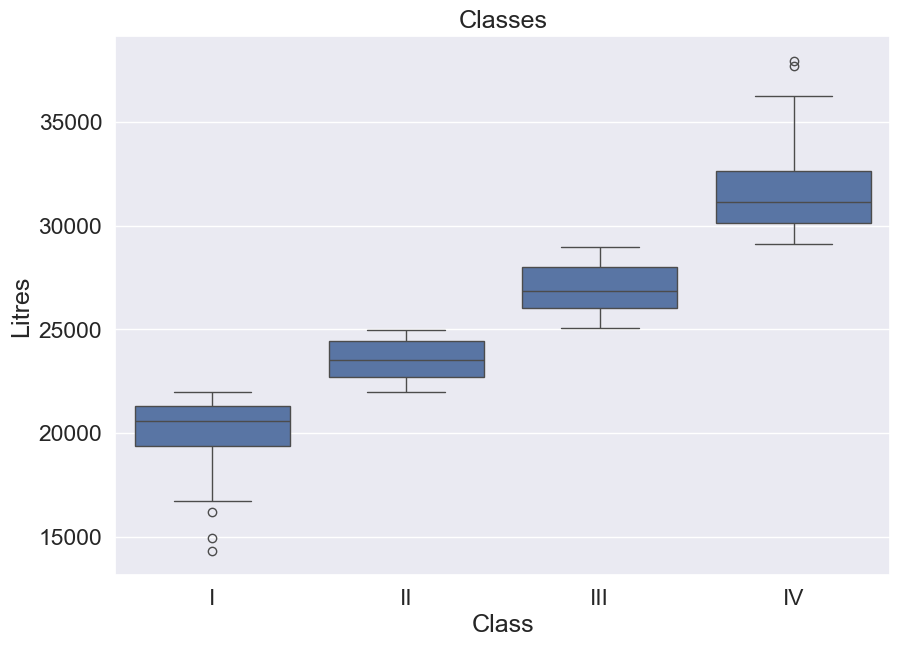

In [59]:
# Just a check of the number of Litres per class
perClass = df.groupby('Class').agg({'Litres':['count','sum','mean','std','min','median', 'max']}).round(1)
print(perClass)

plt.figure(figsize=(10,7))
sns.boxplot(x="Class", y="Litres", data=df)
plt.xticks(range(0,4),["I", "II", "III", "IV"])
plt.title("Classes")
plt.show()

### 1. Feature selection
Is the Date a useful feature for our goal? Would another be useful? How can you check?

In [60]:
# Let's add the season, because why not
df['Season'] = df.Date.dt.month.map({1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1})

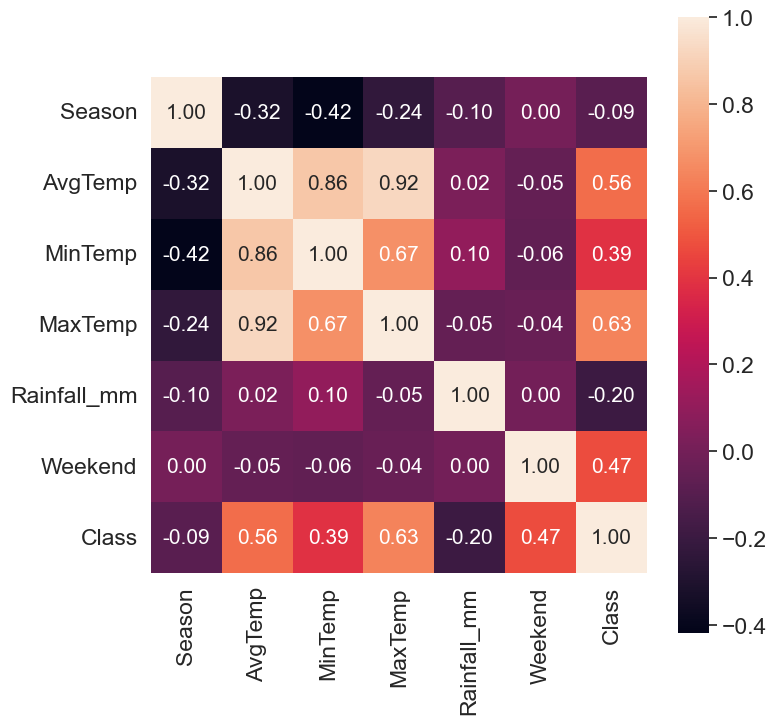

In [61]:
# Plot the correlation matrix for all features except the date
kolomdf = ['Season', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Class']

plt.figure(figsize=(8,8))
cm = np.corrcoef(df[kolomdf].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=kolomdf,
                xticklabels=kolomdf
                )
plt.show()

We'll make a simple model, using only MaxTemp and Weekend as features. AvgTemp and MinTemp are too strongly correlated with MaxTemp, and Rainfall and Season are only very weakly correlated with Class.

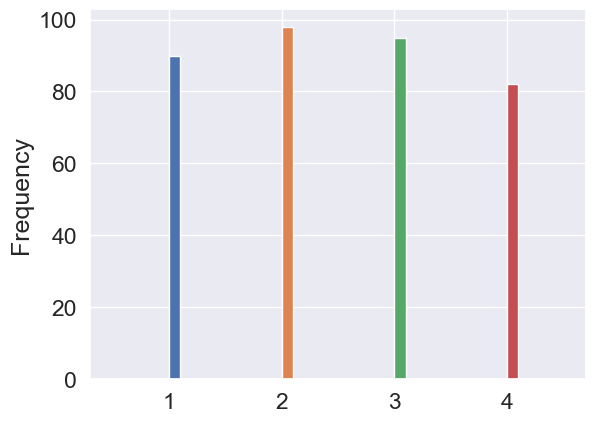

In [62]:
# We'll use as the predictors/features/independent variables MaxTemp and Weekend,
# and the class is the value to be predicted (label/independent var)
labels = df.loc[:,'Class']
data = df.loc[:,['MaxTemp', 'Weekend']]

# Insight into the frequency distribution of the classes;
# They are roughly balanced (as intended)
labels[:].groupby(labels[:]).plot(kind="hist")
plt.show()

# Function that plots the confusion matrix

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot a confusion matrix using seaborn heatmap.

    Parameters
    ----------
    y_true : array-like
        True class labels.
    y_pred : array-like
        Predicted class labels.
    model_name : str, optional
        Title for the plot (default is "Model").
    """
    # Compute confusion matrix
    confmat = confusion_matrix(y_true, y_pred)
    ticks = np.unique(np.concatenate((y_true, y_pred)))
    ticks.sort()

    # Create a seaborn heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confmat,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=ticks,
        yticklabels=ticks,
        square=True
    )

    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

## 2. Baseline models for classification
Code a baseline model

In [64]:
# splits the dataset in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=0)


# give the size of the training and the test set again
print('shape of training set: ', X_train.shape)
print('shape of test set:     ', X_test.shape)

shape of training set:  (273, 2)
shape of test set:      (92, 2)


Accuracy: 0.532608695652174


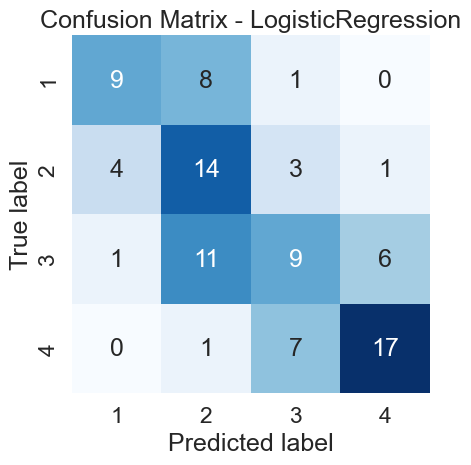

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2.1 Choose a baseline classification model, fill in the blank
baseline_1 = LogisticRegression(max_iter=1000, random_state=42)

baseline_1.fit(X_train, y_train)

y_pred = baseline_1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

plot_confusion_matrix(y_test, y_pred, model_name="LogisticRegression")


Accuracy: 0.43478260869565216


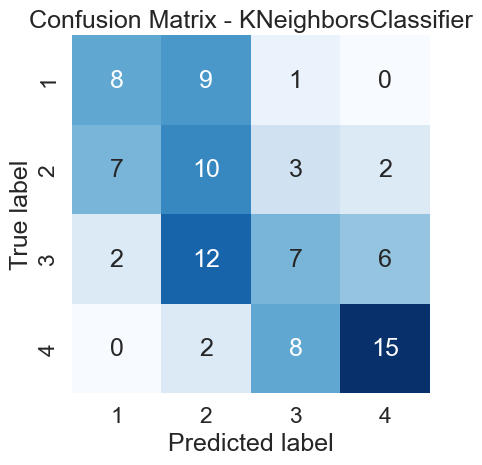

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 2.2 Choose a different baseline classification model, fill in the blank
baseline_2 = KNeighborsClassifier(n_neighbors=5)

baseline_2.fit(X_train, y_train)

y_pred = baseline_2.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

plot_confusion_matrix(y_test, y_pred, model_name="KNeighborsClassifier")


#### Question: how do these models compare? Is there a difference in accuracy? Why do you think this is?

## 3/4. Tree-based models
Code a decision tree and random forest below!

Accuracy: 0.4673913043478261


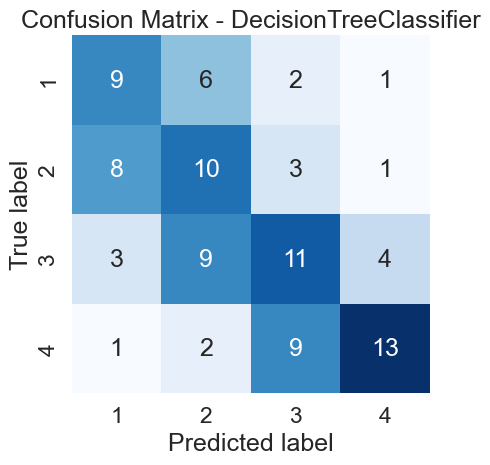

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Fill in the blank with a decision tree model
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

plot_confusion_matrix(y_test, y_pred, model_name="DecisionTreeClassifier")


Accuracy: 0.4782608695652174


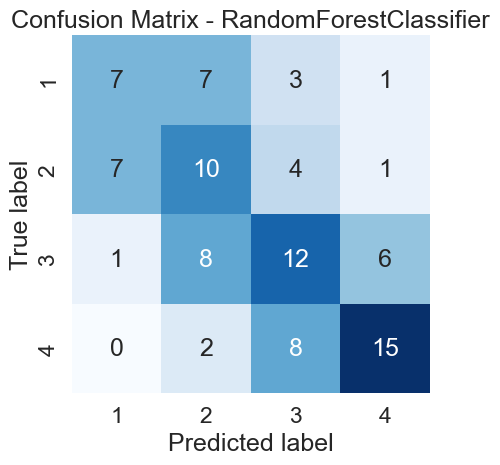

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fill in the blank with a random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

plot_confusion_matrix(y_test, y_pred, model_name="RandomForestClassifier")